In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
DATA_PATH = 'drive/MyDrive/march_madness_2023/march-machine-learning-mania-2023__3-13-23/'

### Read in tournament seeds

In [6]:
df_seeds = pd.read_csv(DATA_PATH + 'MNCAATourneySeeds.csv')
df_seeds = df_seeds[df_seeds.Season >= 2003]
df_seeds = df_seeds[df_seeds.Season < 2023]

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df_seeds['SeedNumeric'] = df_seeds['Seed'].apply(treat_seed)
    
df_seeds.head()

,Season,Seed,TeamID,SeedNumeric
1154,2003,W01,1328,1
1155,2003,W02,1448,2
1156,2003,W03,1393,3
1157,2003,W04,1257,4
1158,2003,W05,1280,5


### Read in season results and create NumWins, NumLosses, GapWins, GapLosses

In [7]:
df_season_results = pd.read_csv(DATA_PATH + 'MRegularSeasonCompactResults.csv')
df_season_results = df_season_results[df_season_results.Season >= 2003]
df_season_results = df_season_results[df_season_results.Season < 2023]

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']
print(df_season_results.shape)
df_season_results.head()

(102032, 7)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
74048,2003,10,1104,68,1328,62,6
74049,2003,10,1272,70,1393,63,7
74050,2003,11,1266,73,1437,61,12
74051,2003,11,1296,56,1457,50,6
74052,2003,11,1400,77,1208,71,6


In [8]:
# number of wins 
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

# number of losses 
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

print(num_loss.shape)
num_loss.head()

(6889, 3)


,Season,TeamID,NumLosses
0,2003,1102,16
1,2003,1103,14
2,2003,1104,11
3,2003,1105,19
4,2003,1106,15


In [9]:
# number of wins over last 14 days
num_win_last14 = df_season_results[df_season_results.DayNum >= 132-14].groupby(['Season', 'WTeamID']).count()
num_win_last14 = num_win_last14.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins14", "WTeamID": "TeamID"})

# number of losses over last 14 days
num_loss_last14 = df_season_results[df_season_results.DayNum >= 132-14].groupby(['Season', 'LTeamID']).count()
num_loss_last14 = num_loss_last14.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses14", "LTeamID": "TeamID"})

print(num_loss_last14.shape)
print(num_loss_last14.NumLosses14.value_counts())
num_loss_last14.head()

(6056, 3)
1    3310
2    1859
3     814
4      73
Name: NumLosses14, dtype: int64


,Season,TeamID,NumLosses14
0,2003,1102,2
1,2003,1103,2
2,2003,1104,2
3,2003,1105,3
4,2003,1106,2


In [10]:
# average score gap for the winning teams
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

# average score gap for the losing teams
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

print(gap_loss.shape)
gap_loss.head()

(6889, 3)


,Season,TeamID,GapLosses
0,2003,1102,11.250000
1,2003,1103,7.500000
2,2003,1104,9.454545
3,2003,1105,11.473684
4,2003,1106,9.266667


In [11]:
# average score gap for the winning teams over last 14 days
gap_win_last14 = df_season_results[df_season_results.DayNum >= 132-14].groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win_last14 = gap_win_last14[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins14", "WTeamID": "TeamID"})

# average score gap for the losing teams over last 14 days
gap_loss_last14 = df_season_results[df_season_results.DayNum >= 132-14].groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss_last14 = gap_loss_last14[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses14", "LTeamID": "TeamID"})

print(gap_loss_last14.shape)
gap_loss_last14.head()

(6056, 3)


,Season,TeamID,GapLosses14
0,2003,1102,4.500000
1,2003,1103,3.000000
2,2003,1104,8.500000
3,2003,1105,3.666667
4,2003,1106,6.500000


### Read in detailed season results and create some advanced metrics

(from https://en.wikipedia.org/wiki/Advanced_statistics_in_basketball)

Possessions = 0.96 * (FGA - ORb + TO + (0.475 * FTA))

Offensive Efficiency (OffEff) = PointsScored * 100 / Possessions

Defensive Efficiency (DefEff) = PointsAllowed * 100 / Possessions

Effective Technical Shooting Percentage (EFT) = (FGM + 0.5 * FGM3) / FGA

In [13]:
df_season_stats = pd.read_csv(DATA_PATH + 'MRegularSeasonDetailedResults.csv')
df_season_stats = df_season_stats[df_season_stats.Season >= 2003]
df_season_stats = df_season_stats[df_season_stats.Season < 2023]
df_season_stats.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

# advanced metrics for winning teams
df_season_stats['WPoss'] = 0.96 * (df_season_stats['WFGA'] - df_season_stats['WOR'] 
                                   + df_season_stats['WTO'] + (0.475 * df_season_stats['WFTA']))
df_season_stats['WOffEff'] = df_season_stats['WScore'] / df_season_stats['WPoss'] * 100
df_season_stats['WDefEff'] = df_season_stats['LScore'] / df_season_stats['WPoss'] * 100
df_season_stats['WEFT'] = (df_season_stats['WFGM'] + 0.5 * df_season_stats['WFGM3']) / df_season_stats['WFGA']

# advanced metrics for losing teams
df_season_stats['LPoss'] = 0.96 * (df_season_stats['LFGA'] - df_season_stats['LOR'] 
                                   + df_season_stats['LTO'] + (0.475 * df_season_stats['LFTA']))
df_season_stats['LOffEff'] = df_season_stats['LScore'] / df_season_stats['LPoss'] * 100
df_season_stats['LDefEff'] = df_season_stats['WScore'] / df_season_stats['LPoss'] * 100
df_season_stats['LEFT'] = (df_season_stats['LFGM'] + 0.5 * df_season_stats['LFGM3']) / df_season_stats['LFGA']

print(df_season_stats.shape)
print(df_season_stats.columns)
df_season_stats.head()

(102032, 40)
Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WFGM',
       'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO',
       'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA',
       'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'WPoss', 'WOffEff',
       'WDefEff', 'WEFT', 'LPoss', 'LOffEff', 'LDefEff', 'LEFT'],
      dtype='object')


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,...,LBlk,LPF,WPoss,WOffEff,WDefEff,WEFT,LPoss,LOffEff,LDefEff,LEFT
0,2003,10,1104,68,1328,62,27,58,3,14,...,2,20,72.528,93.756894,85.484227,0.491379,68.592,90.389550,99.136926,0.433962
1,2003,10,1272,70,1393,63,26,62,8,20,...,6,16,66.264,105.638054,95.074248,0.483871,65.760,95.802920,106.447689,0.402985
2,2003,11,1266,73,1437,61,24,58,8,18,...,5,23,62.184,117.393542,98.095973,0.482759,62.328,97.869336,117.122321,0.321918
3,2003,11,1296,56,1457,50,18,38,3,9,...,3,23,56.376,99.333050,88.690223,0.513158,55.800,89.605735,100.358423,0.428571
4,2003,11,1400,77,1208,71,30,61,6,14,...,1,14,61.608,124.983768,115.244773,0.540984,61.272,115.876746,125.669147,0.435484


In [14]:
# average advanced metrics for winning teams
win_metrics = df_season_stats.groupby(['Season', 'WTeamID']).mean().reset_index()
win_metrics = win_metrics[['Season', 'WTeamID', 'WOffEff', 'WDefEff', 'WEFT']]

# average advanced metrics for losing teams
loss_metrics = df_season_stats.groupby(['Season', 'LTeamID']).mean().reset_index()
loss_metrics = loss_metrics[['Season', 'LTeamID', 'LOffEff', 'LDefEff', 'LEFT']]

print(win_metrics.shape)
print(loss_metrics.shape)
loss_metrics.head()

(6884, 5)
(6889, 5)


,Season,LTeamID,LOffEff,LDefEff,LEFT
0,2003,1102,94.626537,115.946037,0.503591
1,2003,1103,106.003538,117.710095,0.484527
2,2003,1104,98.552254,114.146788,0.429002
3,2003,1105,93.265321,108.981465,0.446777
4,2003,1106,92.268727,106.691278,0.450522


In [15]:
adv_metrics = win_metrics.merge(loss_metrics, 
                                left_on=['Season','WTeamID'],
                                right_on=['Season','LTeamID'],
                                how='outer').drop('LTeamID', axis=1).rename(columns={'WTeamID':'TeamID'})
adv_metrics.fillna(0, inplace=True)

print(adv_metrics.shape)
adv_metrics.head()

(6892, 8)


,Season,TeamID,WOffEff,WDefEff,WEFT,LOffEff,LDefEff,LEFT
0,2003,1102.0,126.012887,96.797867,0.692162,94.626537,115.946037,0.503591
1,2003,1103.0,125.045756,111.736866,0.592604,106.003538,117.710095,0.484527
2,2003,1104.0,113.581339,93.531458,0.506056,98.552254,114.146788,0.429002
3,2003,1105.0,106.669505,89.356373,0.488400,93.265321,108.981465,0.446777
4,2003,1106.0,103.644271,87.931715,0.517668,92.268727,106.691278,0.450522


In [16]:
# average advanced metrics for winning teams over last 14 days
win_metrics_last14 = df_season_stats[df_season_stats.DayNum >= 132-14].groupby(['Season', 'WTeamID']).mean().reset_index()
win_metrics_last14 = win_metrics_last14[['Season', 'WTeamID', 'WOffEff', 'WDefEff', 'WEFT']].rename(columns={'WOffEff':'WOffEff14',
                                                                                                             'WDefEff':'WDefEff14',
                                                                                                             'WEFT':'WEFT14'})

# average advanced metrics for losing teams over last 14 days
loss_metrics_last14 = df_season_stats[df_season_stats.DayNum >= 132-14].groupby(['Season', 'LTeamID']).mean().reset_index()
loss_metrics_last14 = loss_metrics_last14[['Season', 'LTeamID', 'LOffEff', 'LDefEff', 'LEFT']].rename(columns={'LOffEff':'LOffEff14',
                                                                                                             'LDefEff':'LDefEff14',
                                                                                                             'LEFT':'LEFT14'})

print(win_metrics_last14.shape)
print(loss_metrics_last14.shape)
loss_metrics_last14.head()

(4820, 5)
(6056, 5)


,Season,LTeamID,LOffEff14,LDefEff14,LEFT14
0,2003,1102,94.737887,104.217122,0.452031
1,2003,1103,111.583616,116.230664,0.524807
2,2003,1104,102.548189,116.000724,0.450273
3,2003,1105,94.101713,98.766305,0.421889
4,2003,1106,91.743657,101.820296,0.446111


In [17]:
adv_metrics_last14 = win_metrics_last14.merge(loss_metrics_last14, 
                                left_on=['Season','WTeamID'],
                                right_on=['Season','LTeamID'],
                                how='outer').drop('LTeamID', axis=1).rename(columns={'WTeamID':'TeamID'})
adv_metrics_last14.fillna(0, inplace=True)

print(adv_metrics_last14.shape)
adv_metrics_last14.head()

(6635, 8)


,Season,TeamID,WOffEff14,WDefEff14,WEFT14,LOffEff14,LDefEff14,LEFT14
0,2003,1102.0,119.248036,105.218855,0.666667,94.737887,104.217122,0.452031
1,2003,1103.0,120.397464,108.205316,0.580000,111.583616,116.230664,0.524807
2,2003,1104.0,128.534674,93.362310,0.618982,102.548189,116.000724,0.450273
3,2003,1106.0,105.931212,99.654542,0.542959,91.743657,101.820296,0.446111
4,2003,1108.0,99.551349,92.054538,0.453841,96.134903,110.445706,0.447751


### Read in Rankings data

Only using final day (133) of rankings

Only using average of 5 rankings systems with most data i.e. MOR to DOL

If the ranking is NaN, replace with the maximum ranking

In [18]:
df_ranks = pd.read_csv(DATA_PATH + 'MMasseyOrdinals_thru_Season2023_Day128.csv')
df_ranks = df_ranks[df_ranks.Season >= 2003]
df_ranks = df_ranks[df_ranks.Season < 2023]

df_ranks = df_ranks[df_ranks.RankingDayNum == 133].drop(['RankingDayNum'], axis=1)
print(df_ranks.shape)
df_ranks.head()

(332137, 4)


,Season,SystemName,TeamID,OrdinalRank
121021,2003,AP,1112,2
121022,2003,AP,1163,23
121023,2003,AP,1166,15
121024,2003,AP,1173,16
121025,2003,AP,1181,7


In [20]:
# Create a DataFrame for the 5 ranking systems with the most data

df_ranks_clean = df_ranks[df_ranks.SystemName == 'MOR'].drop(['SystemName'], axis=1).rename(columns={'OrdinalRank':'MOR'})
print(df_ranks_clean.shape)

for sys in df_ranks.SystemName.value_counts().index[1:5]:
  tmp = df_ranks[df_ranks.SystemName == sys].drop(['SystemName'], axis=1).rename(columns={'OrdinalRank':sys})
  df_ranks_clean = pd.merge(df_ranks_clean, tmp, on=['Season', 'TeamID'], how='outer')
  sys_max = df_ranks_clean[sys].max()
  df_ranks_clean.fillna(sys_max, inplace=True)

print(df_ranks_clean.shape)
df_ranks_clean

(6538, 3)
(6538, 7)


,Season,TeamID,MOR,SAG,WLK,POM,DOL
0,2003,1102,132,149,165.0,160.0,175.0
1,2003,1103,139,172,172.0,163.0,174.0
2,2003,1104,26,37,36.0,33.0,39.0
3,2003,1105,309,312,310.0,307.0,315.0
4,2003,1106,294,268,254.0,263.0,266.0
...,...,...,...,...,...,...,...
6533,2022,1468,188,195,181.0,199.0,150.0
6534,2022,1469,288,295,277.0,277.0,260.0
6535,2022,1470,249,225,231.0,209.0,231.0
6536,2022,1471,272,266,270.0,255.0,262.0


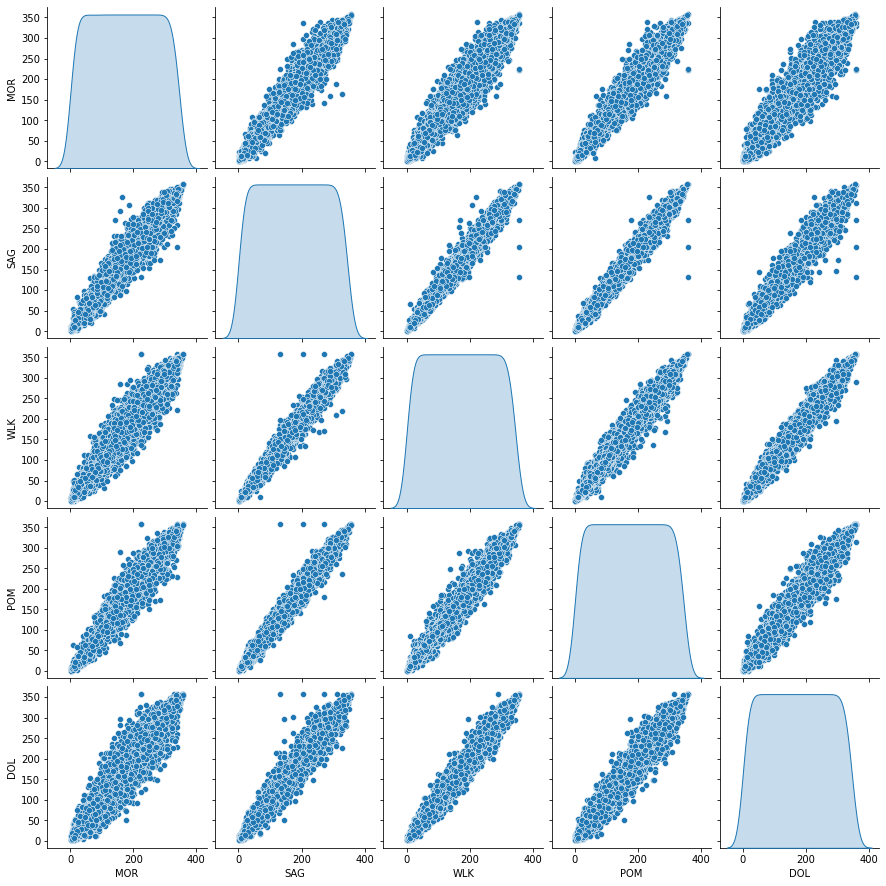

In [21]:
sns.pairplot(df_ranks_clean, vars=['MOR', 'SAG', 'WLK', 'POM', 'DOL'], diag_kind='kde')

In [22]:
# Only use average rank since you do not gain much from including multiple rankings
df_avg_rank = df_ranks_clean.drop(df_ranks.SystemName.value_counts().index[0:5], axis=1)
df_avg_rank['AvgRank'] = df_ranks_clean.drop(['Season', 'TeamID'], axis=1).mean(axis=1)

print(df_avg_rank.shape)
df_avg_rank.head()

(6538, 3)


,Season,TeamID,AvgRank
0,2003,1102,156.2
1,2003,1103,164.0
2,2003,1104,34.2
3,2003,1105,310.6
4,2003,1106,269.0


### Read in tourney results, round

Advanced metrics same as regular season data

Rounds defined by the DayNum of the games:
* Round 0: 134, 135 (play-ins)
* Round 1: 136, 137 (Round of 64)
* Round 2: 138, 139, 140 (Round of 32)
* Round 3: 143, 144 (Sweet Sixteen)
* Round 4: 145, 146, 147, 148 (Elite Eight)
* Round 5: 152 (Final Four)
* Round 6: 154 (Championship)

In [23]:
df_tourney_results = pd.read_csv(DATA_PATH + 'MNCAATourneyCompactResults.csv')
df_tourney_results = df_tourney_results[df_tourney_results.Season >= 2003]

df_tourney_results = df_tourney_results[df_tourney_results.Season < 2023].drop(['WLoc', 'NumOT'], axis=1)
# df_tourney_results['ScoreDiff'] = df_tourney_results['WScore'] - df_tourney_results['LScore']
# df_tourney_results.drop(['WScore', 'LScore'], axis=1, inplace=True)
print(df_tourney_results.shape)
df_tourney_results.head()

(1248, 6)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore
1136,2003,134,1421,92,1411,84
1137,2003,136,1112,80,1436,51
1138,2003,136,1113,84,1272,71
1139,2003,136,1141,79,1166,73
1140,2003,136,1143,76,1301,74


In [24]:
# Skip this until I have a good function for "hotness"

# def day2round(day):
#   if day in [134, 135]:
#     return 0
#   elif day in [136, 137]:
#     return 1
#   elif day in [138, 139, 140]:
#     return 2
#   elif day in [143, 144]:
#     return 3
#   elif day in [145, 146, 147, 148]:
#     return 4
#   elif day == 152:
#     return 5
#   elif day == 154:
#     return 6
#   else:
#     raise TypeError('Unknown round for day {}'.format(day))


# df_tourney_results['Round'] = df_tourney_results.DayNum.apply(day2round)
# df_tourney_results.head()

### Merge all the data into a single DataFrame

In [25]:
# Season, single value data
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_win_last14, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss_last14, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win_last14, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss_last14, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(adv_metrics, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(adv_metrics_last14, on=['Season', 'TeamID'], how='left')

df_features_season.fillna(0, inplace=True) # add zeros where teams won or lost 0 games

df_features_season['OffEff'] = ((df_features_season['WOffEff'] * df_features_season['NumWins'] + 
                                 df_features_season['LOffEff'] * df_features_season['NumLosses']) 
                                / (df_features_season['NumWins'] + df_features_season['NumLosses']))

df_features_season['DefEff'] = ((df_features_season['WDefEff'] * df_features_season['NumWins'] + 
                                 df_features_season['LDefEff'] * df_features_season['NumLosses']) 
                                / (df_features_season['NumWins'] + df_features_season['NumLosses']))

df_features_season['EFT'] = ((df_features_season['WEFT'] * df_features_season['NumWins'] + 
                                 df_features_season['LEFT'] * df_features_season['NumLosses']) 
                                / (df_features_season['NumWins'] + df_features_season['NumLosses']))

df_features_season['OffEff14'] = ((df_features_season['WOffEff14'] * df_features_season['NumWins14'] + 
                                 df_features_season['LOffEff14'] * df_features_season['NumLosses14']) 
                                / (df_features_season['NumWins14'] + df_features_season['NumLosses14']))

df_features_season['DefEff14'] = ((df_features_season['WDefEff14'] * df_features_season['NumWins14'] + 
                                 df_features_season['LDefEff14'] * df_features_season['NumLosses14']) 
                                / (df_features_season['NumWins14'] + df_features_season['NumLosses14']))

df_features_season['EFT14'] = ((df_features_season['WEFT14'] * df_features_season['NumWins14'] + 
                                 df_features_season['LEFT14'] * df_features_season['NumLosses14']) 
                                / (df_features_season['NumWins14'] + df_features_season['NumLosses14']))

df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

df_features_season['WinRatio14'] = df_features_season['NumWins14'] / (df_features_season['NumWins14'] + df_features_season['NumLosses14'])
df_features_season['GapAvg14'] = (
    (df_features_season['NumWins14'] * df_features_season['GapWins14'] - 
    df_features_season['NumLosses14'] * df_features_season['GapLosses14'])
    / (df_features_season['NumWins14'] + df_features_season['NumLosses14'])
)

df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses',
                         'NumWins14', 'NumLosses14', 'GapWins14', 'GapLosses14',
                         'WOffEff', 'LOffEff', 'WDefEff', 'LDefEff', 'WEFT', 'LEFT',
                         'WOffEff14', 'LOffEff14', 'WDefEff14', 'LDefEff14', 'WEFT14', 'LEFT14'], axis=1, inplace=True)
 
df_features_season = df_features_season.merge(df_avg_rank, on=['Season', 'TeamID'], how='left')

print(df_features_season.shape)
df_features_season.head()

(6892, 13)


,Season,TeamID,OffEff,DefEff,EFT,OffEff14,DefEff14,EFT14,WinRatio,GapAvg,WinRatio14,GapAvg14,AvgRank
0,2003,1102,108.077830,107.739678,0.584407,102.907937,104.551033,0.523576,0.428571,0.250000,0.333333,-0.333333,156.2
1,2003,1103,115.172014,114.834096,0.536564,114.521566,113.555548,0.543205,0.481481,0.629630,0.333333,0.666667,164.0
2,2003,1104,107.677056,101.630338,0.475785,115.541432,104.681517,0.534628,0.607143,4.285714,0.500000,7.250000,34.2
3,2003,1105,96.874140,103.697787,0.457983,0.000000,0.000000,0.000000,0.269231,-4.884615,0.000000,-3.666667,310.6
4,2003,1106,97.550229,97.981481,0.481697,98.837434,100.737419,0.494535,0.464286,-0.142857,0.500000,-1.250000,269.0


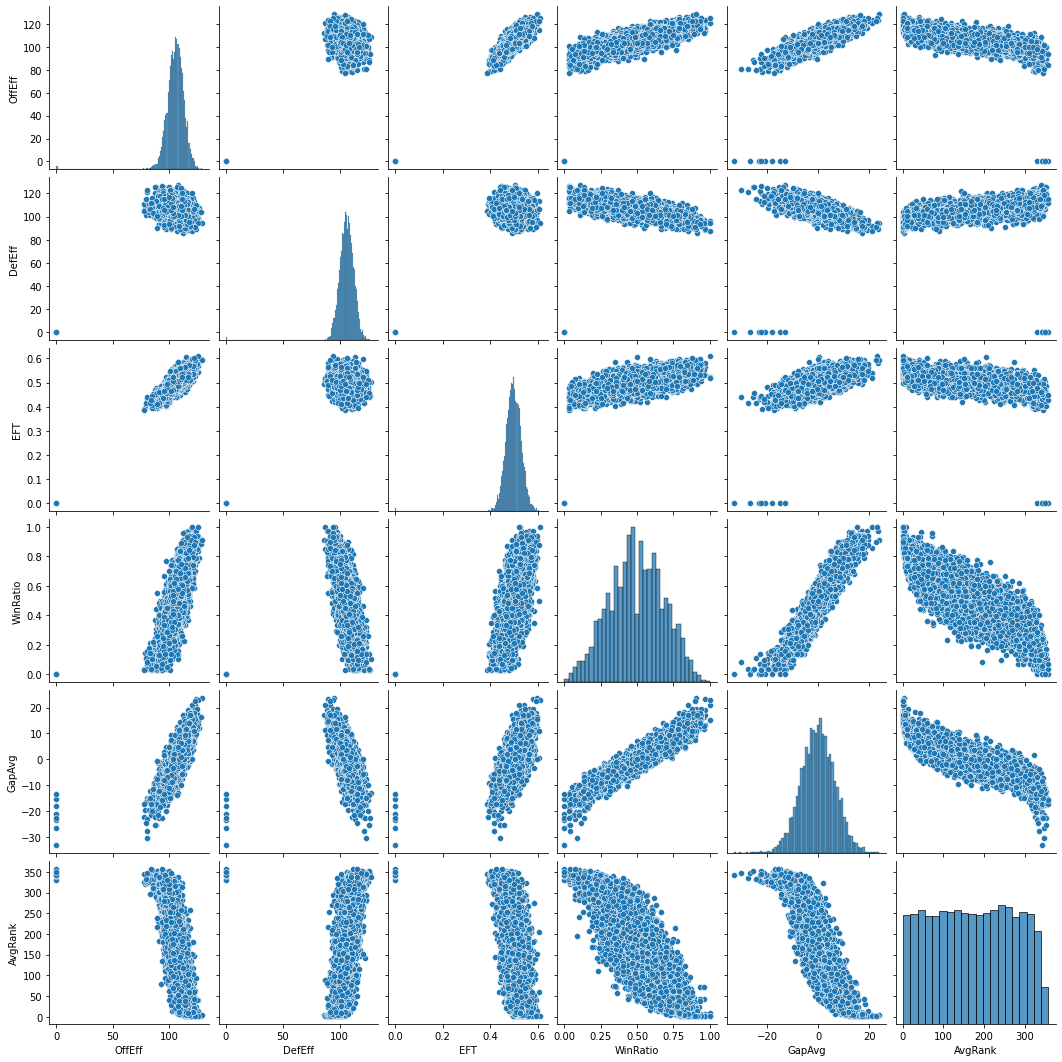

In [26]:
sns.pairplot(df_features_season, vars=['OffEff', 'DefEff', 'EFT', 'WinRatio', 'GapAvg', 'AvgRank'])

In [27]:
# Tournaments and seeds
df_features_tourney = pd.merge(
    df_tourney_results, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID','Seed','DayNum'], axis=1).rename(columns={'SeedNumeric':'SeedW'})

df_features_tourney = pd.merge(
    df_features_tourney, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop(['TeamID', 'Seed'], axis=1).rename(columns={'SeedNumeric': 'SeedL'})

print(df_features_tourney.shape)
df_features_tourney.head()

(1248, 7)


,Season,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2003,1421,92,1411,84,16,16
1,2003,1112,80,1436,51,1,16
2,2003,1113,84,1272,71,10,7
3,2003,1141,79,1166,73,11,6
4,2003,1143,76,1301,74,8,9


In [29]:
# Merge tourney features and season features
df = pd.merge(
    df_features_tourney,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'AvgRank': 'AvgRankW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
    'OffEff': 'OffEffW',
    'DefEff': 'DefEffW',
    'EFT': 'EFTW',
    'WinRatio14': 'WinRatio14W',
    'GapAvg14': 'GapAvg14W',
    'OffEff14': 'OffEff14W',
    'DefEff14': 'DefEff14W',
    'EFT14': 'EFT14W'
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'AvgRank': 'AvgRankL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
    'OffEff': 'OffEffL',
    'DefEff': 'DefEffL',
    'EFT': 'EFTL',
    'WinRatio14': 'WinRatio14L',
    'GapAvg14': 'GapAvg14L',
    'OffEff14': 'OffEff14L',
    'DefEff14': 'DefEff14L',
    'EFT14': 'EFT14L'
}).drop(columns='TeamID', axis=1)

print(df.shape)
print(df.columns)
df.head()

(1248, 29)
Index(['Season', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'SeedW', 'SeedL',
       'OffEffW', 'DefEffW', 'EFTW', 'OffEff14W', 'DefEff14W', 'EFT14W',
       'WinRatioW', 'GapAvgW', 'WinRatio14W', 'GapAvg14W', 'AvgRankW',
       'OffEffL', 'DefEffL', 'EFTL', 'OffEff14L', 'DefEff14L', 'EFT14L',
       'WinRatioL', 'GapAvgL', 'WinRatio14L', 'GapAvg14L', 'AvgRankL'],
      dtype='object')


,Season,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,OffEffW,DefEffW,EFTW,...,DefEffL,EFTL,OffEff14L,DefEff14L,EFT14L,WinRatioL,GapAvgL,WinRatio14L,GapAvg14L,AvgRankL
0,2003,1421,92,1411,84,16,16,105.315164,115.456256,0.489800,...,105.071425,0.503036,110.312541,102.655767,0.534748,0.600000,1.966667,0.833333,5.333333,259.4
1,2003,1112,80,1436,51,1,16,115.232944,95.117513,0.517632,...,99.247639,0.494732,113.140017,94.689354,0.528786,0.655172,4.655172,1.000000,11.250000,159.6
2,2003,1113,84,1272,71,10,7,113.782349,103.406731,0.517334,...,97.004974,0.498337,114.772311,103.328175,0.520348,0.793103,8.689655,0.750000,7.250000,21.8
3,2003,1141,79,1166,73,11,6,114.122499,105.421379,0.572835,...,96.739284,0.567455,111.983454,93.372035,0.516155,0.878788,14.909091,1.000000,13.000000,23.0
4,2003,1143,76,1301,74,8,9,109.611481,102.725168,0.524098,...,105.001178,0.534189,115.099710,115.859787,0.551947,0.600000,4.400000,0.500000,-0.500000,45.0


In [30]:
df.to_csv(DATA_PATH + 'Mfeatures_2003-2022.csv', index=False)

In [31]:
# Add losing matches
def add_losing_matches(df):
    win_rename = {
        "WTeamID": "TeamIDA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIDB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIDB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIDA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)


df = add_losing_matches(df)
print(df.shape)
df.head()

(2496, 29)


,Season,TeamIDA,ScoreA,TeamIDB,ScoreB,SeedA,SeedB,OffEffA,DefEffA,EFTA,...,DefEffB,EFTB,OffEff14B,DefEff14B,EFT14B,WinRatioB,GapAvgB,WinRatio14B,GapAvg14B,AvgRankB
0,2003,1421,92,1411,84,16,16,105.315164,115.456256,0.489800,...,105.071425,0.503036,110.312541,102.655767,0.534748,0.600000,1.966667,0.833333,5.333333,259.4
1,2003,1112,80,1436,51,1,16,115.232944,95.117513,0.517632,...,99.247639,0.494732,113.140017,94.689354,0.528786,0.655172,4.655172,1.000000,11.250000,159.6
2,2003,1113,84,1272,71,10,7,113.782349,103.406731,0.517334,...,97.004974,0.498337,114.772311,103.328175,0.520348,0.793103,8.689655,0.750000,7.250000,21.8
3,2003,1141,79,1166,73,11,6,114.122499,105.421379,0.572835,...,96.739284,0.567455,111.983454,93.372035,0.516155,0.878788,14.909091,1.000000,13.000000,23.0
4,2003,1143,76,1301,74,8,9,109.611481,102.725168,0.524098,...,105.001178,0.534189,115.099710,115.859787,0.551947,0.600000,4.400000,0.500000,-0.500000,45.0


In [32]:
# Compute Difference in Final Score (ScoreDiff) and whether or not the team won (WinA)
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)
df.drop(['ScoreA', 'ScoreB'], axis=1, inplace=True)

print(df.shape)
df.head()

(2496, 29)


,Season,TeamIDA,TeamIDB,SeedA,SeedB,OffEffA,DefEffA,EFTA,OffEff14A,DefEff14A,...,OffEff14B,DefEff14B,EFT14B,WinRatioB,GapAvgB,WinRatio14B,GapAvg14B,AvgRankB,ScoreDiff,WinA
0,2003,1421,1411,16,16,105.315164,115.456256,0.489800,111.471468,103.355312,...,110.312541,102.655767,0.534748,0.600000,1.966667,0.833333,5.333333,259.4,8,1
1,2003,1112,1436,1,16,115.232944,95.117513,0.517632,108.373796,101.570461,...,113.140017,94.689354,0.528786,0.655172,4.655172,1.000000,11.250000,159.6,29,1
2,2003,1113,1272,10,7,113.782349,103.406731,0.517334,116.514025,111.310574,...,114.772311,103.328175,0.520348,0.793103,8.689655,0.750000,7.250000,21.8,13,1
3,2003,1141,1166,11,6,114.122499,105.421379,0.572835,125.801372,100.232903,...,111.983454,93.372035,0.516155,0.878788,14.909091,1.000000,13.000000,23.0,6,1
4,2003,1143,1301,8,9,109.611481,102.725168,0.524098,106.408611,105.008149,...,115.099710,115.859787,0.551947,0.600000,4.400000,0.500000,-0.500000,45.0,2,1


### Save the data to a new csv

In [33]:
df.to_csv(DATA_PATH + 'Mfinal_data_2003-2022.csv', index=False)